# Unobserved Component Model as a Bayesian Model with PyMC

In this notebook I want to deep-dive into the idea of wrapping a [`statsmodels`](https://www.statsmodels.org/stable/index.html) [`UnobservedComponent`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html) model as a bayesian model with [PyMC](https://github.com/pymc-devs/pymc) described in the (great!) post [Fast Bayesian estimation of SARIMAX models](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_pymc3.html). This is a nice excuse to get into some internals of how PyMC works. I hope this can serve as a complement to the original post mentioned above. This post has two parts: In the first one we fit a UnobservedComponent model to a simulated time series. In the second part we describe the process of wrapping the model as a PyMC model, running the MCMC and sampling and generating out od sample predictions.

---

# Part 1: Unobserved Component Model

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style="darkgrid", 
    rc={"axes.facecolor": "0.9", "grid.color": "0.8"}
)
sns.set_palette(palette="deep")
sns_c = sns.color_palette(palette="deep")

plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%reload_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "svg"

## Generate Sample Data

We generate a sample time series with a known trend, seasonal component, an external regressor and an auto-regressive term (see [here](https://github.com/juanitorduz/btsa/blob/master/python/intro_forecasting/unobserved_components.ipynb) for more details).

In [2]:
np.random.seed(1)

min_date = pd.to_datetime("2015-01-01")
max_date = pd.to_datetime("2022-01-01")

data_df = pd.DataFrame(
    data={"date": pd.date_range(start=min_date, end=max_date, freq="M")}
)

n = data_df.shape[0]

def generate_data(n, sigma_eta, sigma_epsilon):
   
    y = np.zeros(n)
    mu = np.zeros(n)
    epsilon = np.zeros(n)
    eta = np.zeros(n)

    for t in range(1, n):
        
        eta[t] = np.random.normal(loc=0.0, scale=sigma_eta)
        mu[t] = mu[t - 1] + eta[t]

        epsilon[t] = np.random.normal(loc=0.0, scale=sigma_epsilon)
        y[t] = mu[t] + epsilon[t]

    return y, mu

sigma_eta = 0.1
sigma_epsilon = 0.1

y, mu = generate_data(n=n, sigma_eta=sigma_eta, sigma_epsilon=sigma_epsilon)

data_df["y"] = y

# Add external regressor.
x = np.random.uniform(low=0.0, high=1.0, size=n)
data_df["x"] = np.where( x > 0.80, x, 0)
# Add seasonal component.
data_df["cs"] = np.sin(2 * np.pi * data_df["date"].dt.dayofyear / 356.5) 
data_df["cc"] = np.cos(3 * np.pi * data_df["date"].dt.dayofyear / 356.5) 
data_df["s"] = data_df["cs"] + data_df["cc"]
# Construct target variable.
data_df["z"] = data_df["y"] + data_df["x"] + data_df["s"]
# Add autoregressive term.
data_df["z"] = data_df["z"] + 0.5 * data_df["z"].shift(1).fillna(0)

Let us plot the time series and its components:

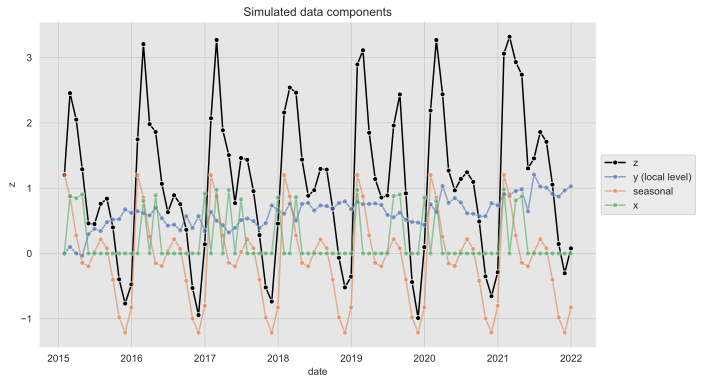

In [3]:
fig, ax = plt.subplots()
sns.lineplot(x="date", y="z", data=data_df, marker="o", markersize=5, color="black", label="z", ax=ax)
sns.lineplot(x="date", y="y", data=data_df, marker="o", markersize=5, color=sns_c[0], alpha=0.6, label="y (local level)", ax=ax)
sns.lineplot(x="date", y="s", data=data_df, marker="o", markersize=5, color=sns_c[1], alpha=0.6, label="seasonal", ax=ax)
sns.lineplot(x="date", y="x", data=data_df, marker="o", markersize=5, color=sns_c[2], alpha=0.6, label="x", ax=ax)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Simulated data components");

## Train-Test Split

Next we split the data into a training and test set.

In [4]:
# Set date as index.
data_df.set_index("date", inplace=True)
data_df.index = pd.DatetimeIndex(
    data=data_df.index.values,
    freq=data_df.index.inferred_freq
)

Let us see the split:

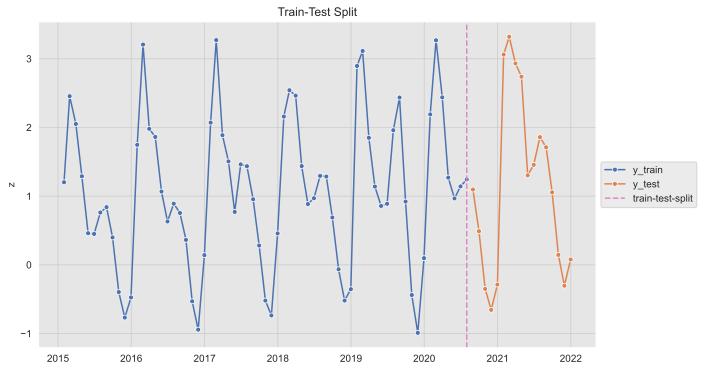

In [5]:
train_test_ratio = 0.80
n_train = int(n * train_test_ratio)
n_test = n - n_train

data_train_df = data_df[: n_train]
data_test_df = data_df[- n_test :]

y_train = data_train_df["z"]
x_train = data_train_df[["x"]]

y_test = data_test_df["z"]
x_test = data_test_df[["x"]]

fig, ax = plt.subplots()
sns.lineplot(x=y_train.index, y=y_train, marker="o", markersize=5, color=sns_c[0], label="y_train", ax=ax)
sns.lineplot(x=y_test.index, y=y_test, marker="o", markersize=5, color=sns_c[1], label="y_test", ax=ax)
ax.axvline(x=x_train.tail(1).index[0], color=sns_c[6], linestyle="--", label="train-test-split")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Train-Test Split");

## Fit Model

We not fit a `UnobservedComponents` model (also known as structural time series models). Recall that this is a model of the form:

$$
y_z = \mu_t + \gamma_t + c_t + \varepsilon_t
$$

where $\mu_t$ is the trend component, $\gamma_t$ is the seasonal component, $c_t$ is the cycle component and $\varepsilon_t$ is the irregular component. Please see the [great documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html) for more details. For this specific case we will use $4$ Fourier terms to model the yearly seasonality (similar to [`prophet`](https://facebook.github.io/prophet/)). In addition, we are going to set the parameter `mle_regression` to `True` to add the external regressor into the state vector.

In [6]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

model_params =  {
    "endog": y_train,
    "exog": x_train,
    "level": "local level",
    "freq_seasonal": [
         {"period": 12, "harmonics": 4}
    ],
    "autoregressive": 1,
    "mle_regression": True,
 }
 
model = UnobservedComponents(**model_params)

Let us now fit the model.

In [7]:
result = model.fit(disp=0)

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                
=============================================================================================
Dep. Variable:                                     z   No. Observations:                   67
Model:                                   local level   Log Likelihood                 -10.895
                   + stochastic freq_seasonal(12(4))   AIC                             33.790
                                             + AR(1)   BIC                             46.153
Date:                               Fri, 10 Dec 2021   HQIC                            38.606
Time:                                       16:19:38                                         
Sample:                                   01-31-2015                                         
                                        - 07-31-2020                                         
Covariance Type:                                 opg                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
sigma2.irregular            6.937e-09      0.115   6.02e-08      1.000      -0.226       0.226
sigma2.level                   0.0024      0.003      0.727      0.467      -0.004       0.009
sigma2.freq_seasonal_12(4)  2.386e-11      0.000   1.74e-07      1.000      -0.000       0.000
sigma2.ar                      0.0489      0.122      0.402      0.688      -0.190       0.288
ar.L1                          0.2854      0.742      0.385      0.700      -1.168       1.739
beta.x                         0.5657      0.070      8.055      0.000       0.428       0.703
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 0.93
Prob(Q):                              0.67   Prob(JB):                         0.63
Heteroskedasticity (H):               1.69   Skew:                             0.28
Prob(H) (two-sided):                  0.26   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now we can see some diagnostic plots:

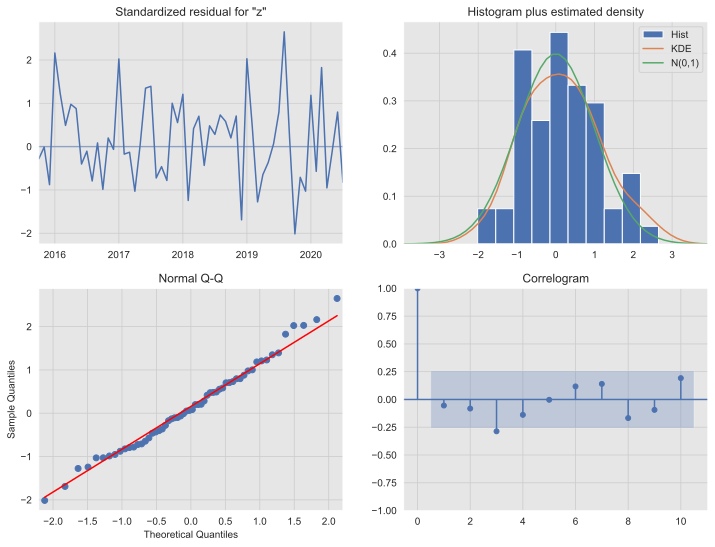

In [8]:
result.plot_diagnostics(figsize=(12, 9));

The error distribution looks ok! Now let us visualize the model (learned) components:

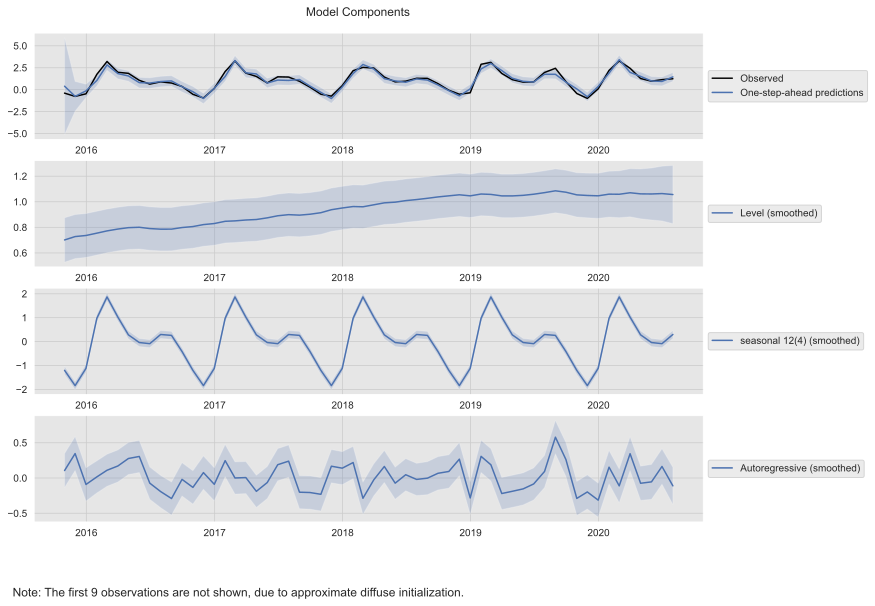

In [9]:
alpha = 0.05

fig = result.plot_components(figsize=(12, 9), alpha=alpha)

for ax in fig.get_axes():
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set(title=None)

fig.suptitle("Model Components", y=0.92);

This decomposition agrees with our data generation process.

**Remark:** Let us get the number of observations needed for the approximate diffuse initialization (see [here](https://github.com/juanitorduz/btsa/blob/master/python/intro_forecasting/unobserved_components.ipynb) for more details).

In [10]:
n_obs_init = model.k_states - int(model._unused_state) - model.ar_order

## Generate Predictions

Now we can use the fitted model to generate in and out sample predictions and confidence intervals.

In [11]:
train_predictions_summary = result \
    .get_prediction() \
    .summary_frame(alpha=alpha)

test_predictions_summary = result \
    .get_forecast(steps=n_test, exog=x_test) \
    .summary_frame(alpha=alpha)

Moreover, we can simulate from the state space model.

In [12]:
repetitions = 100

simulations_train_df = result.simulate(
    anchor="start",
    nsimulations=n_train,
    repetitions=repetitions,
    exog=x_train
)

simulations_test_df = result.simulate(
    anchor="end",
    nsimulations=n_test,
    repetitions=repetitions,
    exog=x_test
)

# Verify expected shape of the simulations dataframes.
assert simulations_train_df.shape == (n_train, repetitions)
assert simulations_test_df.shape == (n_test, repetitions)

Let us see the results:

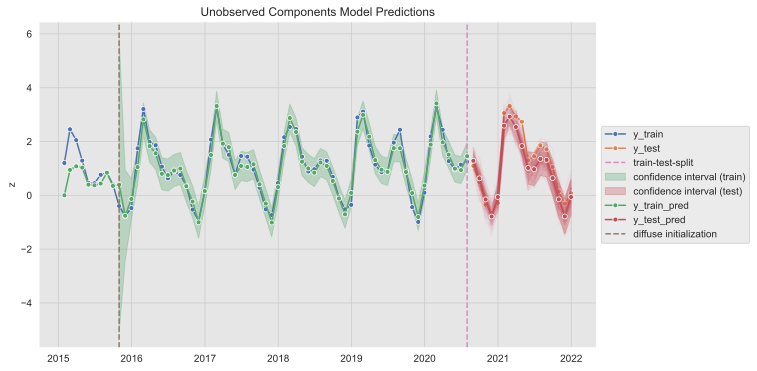

In [13]:
fig, ax = plt.subplots()

# Input data
sns.lineplot(
    x=y_train.index,
    y=y_train,
    marker="o",
    markersize=5,
    color="C0",
    label="y_train",
    ax=ax
)
sns.lineplot(
    x=y_test.index,
    y=y_test,
    marker="o",
    markersize=5,
    color="C1",
    label="y_test",
    ax=ax
)
ax.axvline(
    x=x_train.tail(1).index[0],
    color="C6",
    linestyle="--",
    label="train-test-split"
)

# Simulations
for col in simulations_test_df.columns:
    sns.lineplot(
        x=simulations_test_df.index,
        y=simulations_test_df[col],
        color="C3",
        alpha=0.05, 
        ax=ax
    )

# Prediction intervals
ax.fill_between(
    x=train_predictions_summary.index[n_obs_init: ],
    y1=train_predictions_summary["mean_ci_lower"][n_obs_init: ],
    y2=train_predictions_summary["mean_ci_upper"][n_obs_init: ],
    color="C2",
    label="confidence interval (train)",
    alpha=0.3
)
ax.fill_between(
    x=test_predictions_summary.index[n_obs_init: ],
    y1=test_predictions_summary["mean_ci_lower"][n_obs_init: ],
    y2=test_predictions_summary["mean_ci_upper"][n_obs_init: ],
    color="C3",
    label="confidence interval (test)",
    alpha=0.3
)

# Predictions
sns.lineplot(
    x=train_predictions_summary.index,
    y=train_predictions_summary["mean"],
    marker="o",
    markersize=5,
    color="C2",
    label="y_train_pred",
    ax=ax
)
sns.lineplot(
    x=test_predictions_summary.index,
    y=test_predictions_summary["mean"],
    marker="o",
    markersize=5,
    color="C3",
    label="y_test_pred",
    ax=ax
)

# diffuse initialization
ax.axvline(
    x=y_train.index[n_obs_init],
    color="C5",
    linestyle="--",
    label="diffuse initialization"
)

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Unobserved Components Model Predictions");

Here are some remarks:
- The in and out sample predictions look good and there is no sign of significant over-fit.
- Nevertheless, it seems that the models is underestimating the trend component a bit.
- Note that all the simulations lie withing the confidence intervals.

---

# Part 2: PyMC Integration

As mentioned in the introduction, we follow the indications of the post Fast Bayesian estimation of SARIMAX models](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_pymc3.html) to wrap the model as a PyMC model. Let us break down the steps:

In [14]:
import arviz as az
import pymc3 as pm
import theano.tensor as tt


class Loglike(tt.Op):

    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, model):
        self.model = model
        self.score = Score(self.model)

    def perform(self, node, inputs, outputs):
        (theta,) = inputs  # contains the vector of parameters
        llf = self.model.loglike(theta)
        outputs[0][0] = np.array(llf)  # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        (theta,) = inputs  # our parameters
        out = [g[0] * self.score(theta)]
        return out


class Score(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, model):
        self.model = model

    def perform(self, node, inputs, outputs):
        (theta,) = inputs
        outputs[0][0] = self.model.score(theta)

In [15]:
loglike = Loglike(model)

In [16]:
# Set sampling params
ndraws = 4000  # number of draws from the distribution
nburn = 1000  # number of "burn-in points" (which will be discarded)

In [17]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                
=============================================================================================
Dep. Variable:                                     z   No. Observations:                   67
Model:                                   local level   Log Likelihood                 -10.895
                   + stochastic freq_seasonal(12(4))   AIC                             33.790
                                             + AR(1)   BIC                             46.153
Date:                               Fri, 10 Dec 2021   HQIC                            38.606
Time:                                       16:19:48                                         
Sample:                                   01-31-2015                                         
                                        - 07-31-2020                                         
Covariance Type:                                 opg                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
sigma2.irregular            6.937e-09      0.115   6.02e-08      1.000      -0.226       0.226
sigma2.level                   0.0024      0.003      0.727      0.467      -0.004       0.009
sigma2.freq_seasonal_12(4)  2.386e-11      0.000   1.74e-07      1.000      -0.000       0.000
sigma2.ar                      0.0489      0.122      0.402      0.688      -0.190       0.288
ar.L1                          0.2854      0.742      0.385      0.700      -1.168       1.739
beta.x                         0.5657      0.070      8.055      0.000       0.428       0.703
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 0.93
Prob(Q):                              0.67   Prob(JB):                         0.63
Heteroskedasticity (H):               1.69   Skew:                             0.28
Prob(H) (two-sided):                  0.26   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
with pm.Model() as pm_model:
    # Priors
    sigma2_irregular = pm.InverseGamma("sigma2.irregular", alpha=2, beta=1)
    sigma2_level = pm.InverseGamma("sigma2.level", alpha=2, beta=1)
    sigma2_freq_seasonal = pm.InverseGamma("sigma2.freq_seasonal_12(4)", alpha=2, beta=1)
    sigma2_ar = pm.InverseGamma("sigma2.ar", alpha=2, beta=1)
    ar_L1 = pm.Uniform("ar.L1", lower=-0.99, upper=0.99)
    beta_x = pm.Normal("beta.x", mu=0, sigma=1)

    # convert variables to tensor vectors
    theta = tt.as_tensor_variable([
        sigma2_irregular,
        sigma2_level,
        sigma2_freq_seasonal,
        sigma2_ar,
        ar_L1,
        beta_x
    ])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist("likelihood", logp=loglike, observed=theta)

    # Draw samples
    trace = pm.sample(
        draws=ndraws,
        tune=nburn,
        chains=4,
        return_inferencedata=True,
        cores=-1,
        compute_convergence_checks=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta.x, ar.L1, sigma2.ar, sigma2.freq_seasonal_12(4), sigma2.level, sigma2.irregular]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 275 seconds.


In [19]:
pm_model

In [20]:
from arviz.utils import Numba
Numba.disable_numba()

az.plot_trace(
    data=trace,
    lines=[(k, {}, [v]) for k, v in dict(result.params).items()]
)
plt.tight_layout()

/var/folders/4r/dzmwyydj3mbggyfwbs1cklvh0000gn/T/ipykernel_98529/1578998113.py:8: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


In [21]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta.x,0.415,0.334,-0.188,1.084,0.003,0.002,16352.0,11791.0,1.0
sigma2.irregular,0.194,0.073,0.081,0.324,0.001,0.000,16094.0,12768.0,1.0
sigma2.level,0.183,0.071,0.077,0.315,0.001,0.000,16553.0,11921.0,1.0
sigma2.freq_seasonal_12(4),0.058,0.013,0.036,0.082,0.000,0.000,16286.0,11846.0,1.0
sigma2.ar,0.213,0.084,0.082,0.364,0.001,0.001,16716.0,11485.0,1.0
ar.L1,0.449,0.300,-0.056,0.989,0.002,0.002,15226.0,8537.0,1.0


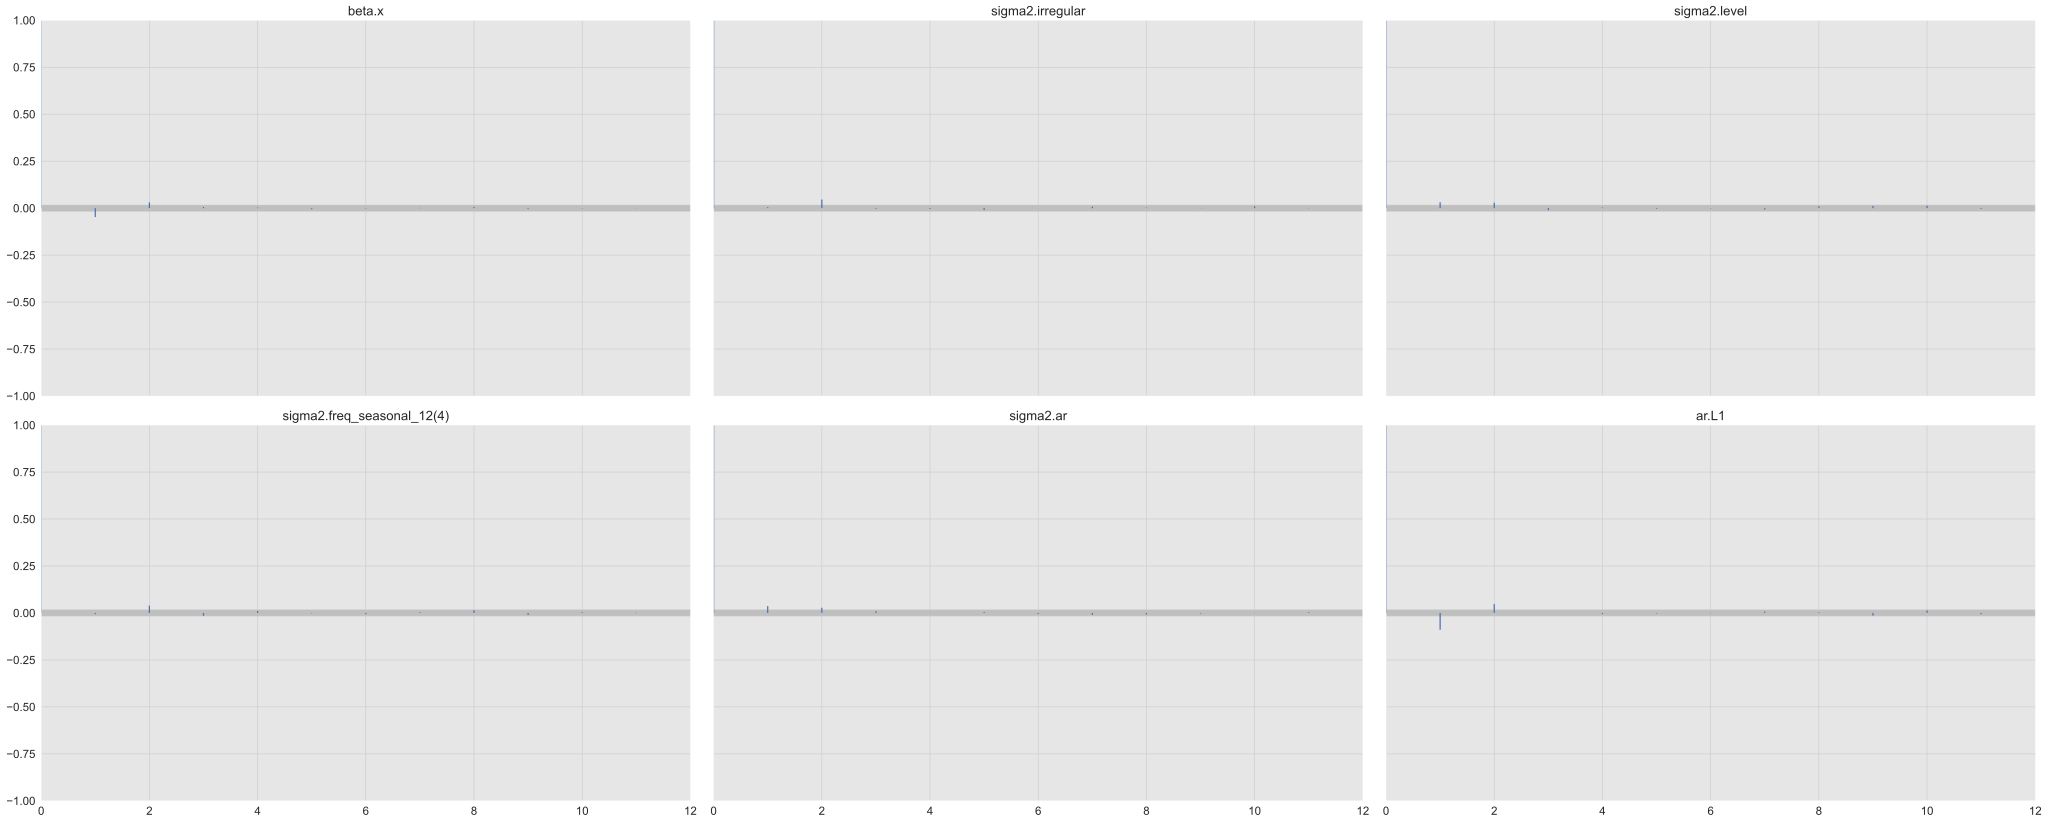

In [22]:
az.plot_autocorr(data=trace, combined=True, max_lag=12);

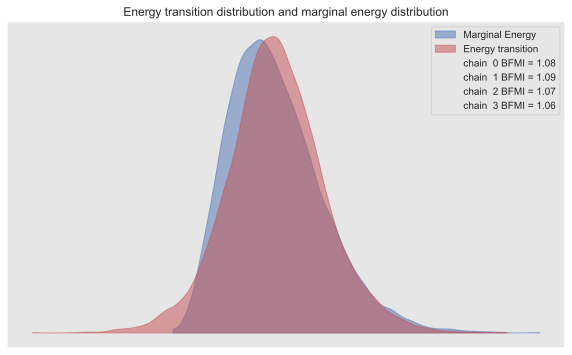

In [23]:
fig, ax = plt.subplots()

az.plot_energy(
    data=trace,
    fill_color=("C0", "C3"),
    fill_alpha=(0.5, 0.5),
    ax=ax
)
ax.set(
    title="Energy transition distribution and marginal energy distribution"
);

In [24]:
n_samples = 200

posterior_samples = trace["posterior"] \
    .stack(sample=("chain", "draw")) \
    .to_pandas() \
    .sample(n=n_samples, replace=True)

posterior_samples = posterior_samples[result.params.index.to_numpy()]

In [25]:
sim_test_list = []
pm_models = []

for i in range(n_samples):
    params = posterior_samples.iloc[i].to_numpy()
    result_bayes = model.smooth(params=params)
    pm_models.append(result_bayes)

train_fitted_values_df = pd.concat(
    [m.fittedvalues[n_obs_init: ] for m in pm_models],
axis=1)

test_predicted_values_df = pd.concat(
    [m.forecast(steps=n_test, exog=x_test) for m in pm_models],
axis=1)
test_predicted_values_df.columns = [f"c_{i}" for i in range(test_predicted_values_df.shape[1])]

sim_test_df  = pd.concat(
    [
        m.simulate(
            anchor="end",
            nsimulations=n_test,
            repetitions=1,
            exog=x_test
        )
        for m in pm_models
    ],
axis=1)
sim_test_df.columns = [f"c_{i}" for i in range(sim_test_df.shape[1])]

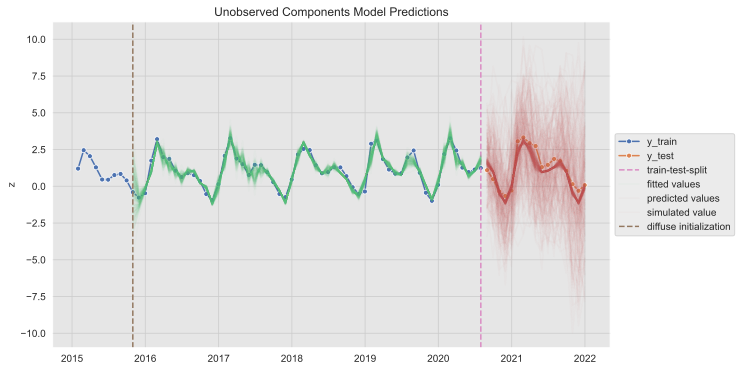

In [26]:
fig, ax = plt.subplots()

# Input data
sns.lineplot(
    x=y_train.index,
    y=y_train,
    marker="o",
    markersize=5,
    color=sns_c[0],
    label="y_train",
    ax=ax
)
sns.lineplot(
    x=y_test.index,
    y=y_test,
    marker="o",
    markersize=5,
    color=sns_c[1],
    label="y_test",
    ax=ax
)
ax.axvline(
    x=x_train.tail(1).index[0],
    color=sns_c[6],
    linestyle="--",
    label="train-test-split"
)

# Predictions

for i, col in enumerate(train_fitted_values_df.columns):

    label = "fitted values" if i == 0 else None
    sns.lineplot(
        x=train_fitted_values_df.index,
        y=train_fitted_values_df[col],
        color="C2",
        alpha=0.03,
        label=label,
        ax=ax
    )

for i, col in enumerate(test_predicted_values_df.columns):
    label = "predicted values" if i == 0 else None
    sns.lineplot(
        x=test_predicted_values_df.index,
        y=test_predicted_values_df[col],
        color="C3",
        alpha=0.03,
        label=label,
        ax=ax
    )

for i, col in enumerate(sim_test_df.columns):
    label = "simulated value" if i == 0 else None
    sns.lineplot(
        x=sim_test_df.index,
        y=sim_test_df[col],
        color="C3",
        alpha=0.03,
        label=label,
        ax=ax
    )

# diffuse initialization
ax.axvline(
    x=y_train.index[n_obs_init],
    color="C5",
    linestyle="--",
    label="diffuse initialization"
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Unobserved Components Model Predictions");